# Importo Pacchetti

In [1]:
import numpy as np
import os
import importlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from numba import jit
import nolds
import sys
sys.path.insert(0,'./fortran_package/') # carico la directory con i pacchetti
import maps
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import plotly.graph_objects as go
import plotly.io as pio
import ComputeLE
import evaLEs
import time 

In [150]:
importlib.reload(maps)

<module 'maps' from '/home/edo/Università/DNL/Seminario_Finale/Code/./fortran_package/maps.cpython-38-x86_64-linux-gnu.so'>

# Simulo la dinamica

In [2]:
def LV(t, val, a, r):
    """
    Questa funzione definisce gli incrementi secondo il formato utile a 'solve_ivp' di scykit_learn.
    """
    ss = [np.sum(val * i) for i in a]
    diff = [i * x * (1 - s ) for i, x, s in zip(r, val, ss)]
    return diff


def scikit_ivp_solver(t, init, a, r, my_method):
    """
    Chiamo la funzione di IVP ed return degli array con soluzione
    """
    # Chiamata al Solver:
    sol = solve_ivp(LV,            # Funzione con gli incrementi definita sopra
                    [t[0], t[-1]],     # Span di integrazione (intervallo in cui vuoi integrare), ho messo l'intero t
                    init,              # Valori iniziali 
                    t_eval=t,          # Vettore con i tempi in cui vuoi valutare il problema
                    args=[a, r],# Argomenti richiesti dall'IVP 
                    method=my_method,  # Metodo di integrazione (tipo 'RK45', 'Radau',...)
                    max_step = 0.1)  
                                       # Per tutti i metodi visita --> 
    # --> https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp
    
    # I risultati stanno in sol.y
    #x = sol.y[0,:]     # [0,:] indica che prendo tutti i punti in posizione 0
    #y = sol.y[1,:]     # [1,:] indica che prendo tutti i punti in posizione 1
    #z = sol.y[2,:]     # [2,:] indica che prendo tutti i punti in posizione 2
    return sol.y

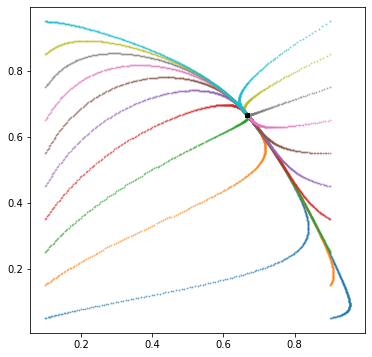

In [3]:
def phase_portrait2(my_method):
    """
    Main per integrare con il metodo my_method (da passare a solve_ivp).
    Restitiusce il plot (da gestire esternamente con plt.show(), ad esempio).
    """
    n = 2000
    t = np.linspace(0, 100, n)
    
    # Parameters
    a = np.array([[1, 0.5],
                  [0.5, 1]])
    r = np.array([0.7, 0.4])
    param = [a, r]
    
    # Inital Values
    #inx = np.arange(0, 1, 0.1)
    inx = np.array([0.1]*10+[0.9]*10)
    iny = np.linspace(0.05,0.95, 10)
    iny = np.concatenate((iny, iny))
    plt.figure(figsize=(6,6))
    for x0, y0 in zip(inx, iny):
        init = [x0, y0]
        s = scikit_ivp_solver(t, init, *param, my_method)
        x = s[0,:]
        y = s[1,:]
        plt.scatter(x, y, s=1, alpha=0.5)
        
    init = [(1-a[0][1])/(1-a[0][1]*a[1][0]), (1-a[1][0])/(1-a[0][1]*a[1][0])]
    s = scikit_ivp_solver(t, init, *param, my_method)
    x = s[0,:]
    y = s[1,:]
    plt.scatter(x, y, s=10, c='k', marker='x')
    plt.show()
phase_portrait2('DOP853')

In [4]:
def main_4initial(my_method, show = False):
    """
    Main per integrare con il metodo my_method (da passare a solve_ivp).
    Restitiusce il plot (da gestire esternamente con plt.show(), ad esempio).
    """
    n = 200000
    t = np.linspace(0, 2000, n)
    
    # Parameters
    a = np.array([[1,    1.09, 1.52, 0   ],
                  [0,    1,    0.44, 1.36],
                  [2.33, 0,    1,    0.47],
                  [1.21, 0.51, 0.35, 1   ]])
    r = np.array([1, 0.72,     1.53, 1.27])
    param = [a, r]
    
    # Inital Values
    #init = [(1-a[0][1])/(1-a[0][1]*a[1][0]), (1-a[1][0])/(1-a[0][1]*a[1][0])]
    init = [0.3, 0.3, 0.1, 0.5]
    
    # Richiamo il "gestore di integrazione"
    s = scikit_ivp_solver(t, init, *param, my_method)
    print(init)
    x = s[0,:]
    y = s[1,:]
    z = s[2,:]
    w = s[3,:]
    if show:
        marker_data = go.Scatter3d(
                        x=x[::10],
                        y=y[::10], 
                        z=z[::10], 
                        marker=go.scatter3d.Marker(size=1, color='blue'), 
                        opacity=0.1, 
                        mode='markers',)
        fig=go.Figure(data=marker_data)
        fig.show()
main_4initial('DOP853')

[0.3, 0.3, 0.1, 0.5]


In [3]:
def confronto(my_method, show = False):
    """
    Main per integrare con il metodo my_method (da passare a solve_ivp).
    Restitiusce il plot (da gestire esternamente con plt.show(), ad esempio).
    """
    n = 200000
    t = np.linspace(0, 2000, n)
    
    # Parameters
    a = np.array([[1,    1.09, 1.52, 0   ],
                  [0,    1,    0.44, 1.36],
                  [2.33, 0,    1,    0.47],
                  [1.21, 0.51, 0.35, 1   ]])
    r = np.array([1, 0.72,     1.53, 1.27])
    param = [a, r]
    
    # Inital Values
    #init = [(1-a[0][1])/(1-a[0][1]*a[1][0]), (1-a[1][0])/(1-a[0][1]*a[1][0])]
    init = [0.3, 0.3, 0.1, 0.5]
    xx = np.ones(n)*init[0]
    yy = np.ones(n)*init[1]
    zz = np.ones(n)*init[2]
    ww = np.ones(n)*init[3]
    #a = a.flatten()
    maps.lv4d(xx, yy, zz, ww, r, a, 0.05, n)
    #plt.plot(xx[:100], alpha=0.4)
    if show:
        marker_data = go.Scatter3d(
                        x=xx[::5],
                        y=yy[::5], 
                        z=zz[::5], 
                        marker=go.scatter3d.Marker(size=1, color='blue'), 
                        opacity=0.1, 
                        mode='markers',)
        fig=go.Figure(data=marker_data)
        fig.show()
confronto('DOP853', show=False)

## Esponenti di Lyapunov

In [14]:
from numba import jit, njit
@njit
def LV(t, val, p):
    """
    Questa funzione definisce gli incrementi secondo il formato utile a 'solve_ivp' di scykit_learn.
    """
    D = len(val)
    a = np.reshape(p[D:], (D,D))
    r = p[:D]
    ss = [np.sum(val * i) for i in a]
    diff = [r[i] * val[i] * (1 - ss[i] ) for i in range(len(r))]
    return np.array(diff)

@njit
def LVJac(t, val, p):
    D = len(val)
    a = np.reshape(p[D:], (D,D))
    r = p[:D]
    s = [np.sum(val * a[i]) for i in range(len(a))]
    J = np.empty(np.shape(a))
    for i in range(len(r)):
        for j in range(len(r)):
            if i == j: 
                J[i][j] = r[i] * (1 - s[i]) - r[i] * val[i] * a[i][j]
            else:
                J[i][j] = - r[i] * val[i] * a[i][j]
    return J

In [15]:
#import evaLEs
#importlib.reload(evaLEs)
import time

D = 20
np.random.seed(46895045)


a = np.array([[1,    1.09, 1.52, 0   ],
              [0,    1,    0.44, 1.36],
              [2.33, 0,    1,    0.47],
              [1.21, 0.51, 0.35, 1   ]], dtype=np.float64)
r = np.array([1, 0.72,     1.53, 1.27], dtype=np.float64)
param = np.append(r, a.flatten())

init = np.array([0.1, 0.1, 0.1, 0.1], dtype=np.float64)


ttrans = np.arange(0.0, 10000, 0.1, dtype=np.float64)
#ttrans = None
t = np.arange(0.0, 1000, 0.01, dtype=np.float64)
start = time.time()
LE, dead = evaLEs.computeLE(LV, LVJac, init, t, param, ttrans)
print(time.time()-start)
print(LE[-1])

7.751502513885498
[ 1.89155654e-02  8.29673486e-04 -2.78610847e-01 -1.03025269e+00]


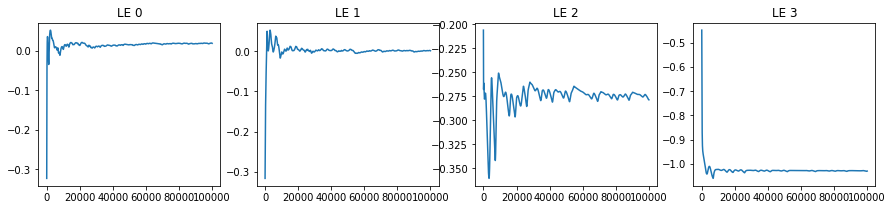

In [207]:
fig, axs = plt.subplots(1, 4, figsize=(15, 3))
for i, (ax, le) in enumerate(zip(axs.flat, LE.T)):
    ax.plot(le)
    ax.set_title(f'LE {i}')

In [139]:
#importlib.reload(ComputeLE)
from tqdm.notebook import tqdm
import time
init = np.array([0.1, 0.1, 0.1, 0.1])
n = 100000
ttrans = np.linspace(0, 20000, n)
t = np.linspace(0, 10000, n)
start = time.time()
a, r, LE, save, d = ComputeLE.find_best(init, t, ttrans=ttrans, n = 400, seed=np.random.randint(0, 100), patience=10, early_stopping=False)
print(time.time()-start)

63.281997203826904


Dead Simulation: 348
Lyapunov Exponent:
 [-0.00546192 -0.00558671 -0.19485251 -1.08537736]

Parameters:
a:
[[1.         0.75987632 1.26440455 0.76160937]
 [0.94882449 1.         1.01248109 0.61010803]
 [0.40527288 1.61486119 1.         0.53297327]
 [1.01082872 0.47939025 1.04534305 1.        ]]
r:
[1.         1.48796744 0.95393584 0.81967327]

Exponent updated 4 times.


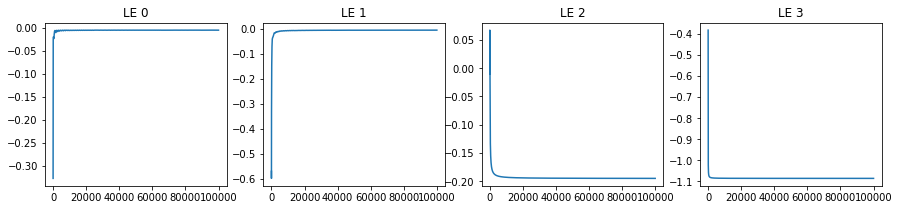

In [140]:
print('Dead Simulation:', d)
print('Lyapunov Exponent:\n', LE[-1])
print(f'\nParameters:\na:\n{a}\nr:\n{r}')
print(f'\nExponent updated {save} times.')
fig, axs = plt.subplots(1, 4, figsize=(15, 3))
for i, (ax, le) in enumerate(zip(axs.flat, LE.T)):
    ax.plot(le)
    ax.set_title(f'LE {i}')

In [17]:
def view(a, r):
    n = 200000
    t = np.linspace(0, 20000, n)
    # Inital Values
    init = np.array([0.1, 0.1, 0.1, 0.1])
    x = np.ones((n, 4))*init
    x = ComputeLE.motion(t, x, a, r)
    xx = x[:,0]
    yy = x[:,1]
    zz = x[:,2]
    ww = x[:,3]
    marker_data = go.Scatter3d(
                    x=xx[::10],
                    y=yy[::10], 
                    z=zz[::10], 
                    marker=go.scatter3d.Marker(size=1, color='blue'), 
                    opacity=0.1, 
                    mode='markers',)
    fig=go.Figure(data=marker_data)
    fig.show()
    print(xx[-1], yy[-1], zz[-1], ww[-1])
view(a, r)

0.22091395248412254 0.37329434913345033 0.2543058940247887 0.43171622059569287


In [ ]:
"""
--> Cool Periodic Orbit:
    Parameters:
    a:
    [[1.         1.43471146 0.74491111 0.34621858]
     [0.34884148 1.         1.10981946 1.54666483]
     [0.84511431 0.56446351 1.         1.45172517]
     [1.3609575  0.96603015 0.20631601 1.        ]]
    r:
    [1.         0.94391483 1.08315685 1.39923605]
    
    
--> Explosive motion (Double spiral):
    a:
    [[1.         0.67555526 1.19967931 1.09911675]
     [0.99459261 1.         1.03146943 0.62733949]
     [0.69996916 1.32858895 1.         1.67360919]
     [0.88072532 1.15027949 1.01192513 1.        ]]
    r:
    [1.         2.09862873 2.07288262 2.16570777]
--> Explosive motion (Single Spiral):
    a:
    [[1.         0.96377237 1.22925258 0.82965361]
     [0.95381588 1.         1.37768824 0.87791643]
     [1.19177367 0.43274872 1.         1.02692937]
     [1.23773181 0.58689249 0.55709525 1.        ]]
    r:
    [1.         2.3237824  2.09250058 2.52372275]
"""

Stai valutando una matrice di 16777216 punti
[1.000e+00 9.000e+00 4.700e+01 1.930e+02 7.820e+02 3.099e+03]
D = 2.0147562323787147 pm 0.008161776344525596


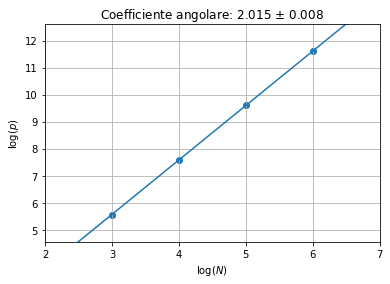

[1.000e+00 9.000e+00 4.700e+01 1.930e+02 7.820e+02 3.099e+03]
131.57085847854614


In [5]:
def box_space_upgraded(xx, x, n, nlim, occ):
    """
    Si può migliorare l'algoritmo di box counting per il solo conteggio di quadrati occupati.
    La struttura è la stessa di box_space, adesso la matrice la inizializziamo nella funzione in modo tale da 
    non perdere risoluzione nella discesa (e non saturare la memoria per creare matrici enormi).
    In conclusione la matrice non è più restituita, si restiuisce solo i quadrati occupati per livello.
    """
    bool_value, x = is_inside_upgraded(xx, x)
    if bool_value: # guardo se all'interno del quadrato c'è la mappa
        occ[n] = occ[n]+1
        if n == nlim: # Se siamo al sotto quadrato limite
            return occ # Inserisco una sottomatrice di 1
        else: # Se non siamo ancora al limite
            goxx = np.empty((xx.shape[0], 3))
            for i, xi in enumerate(xx):
                goxx[i] = np.linspace(xi[0], xi[-1], 3)
            mx = goxx[0]
            my = goxx[1]
            occ = go_inside_upgraded(goxx, x, n, nlim, occ) # Rientro nei 4 sottoquadranti e itero la ricerca
    return occ

def take_from_bin(x, binary):
    strnum = binary[2:]
    strnum = '0'*(len(x) - len(strnum)) + strnum
    out = np.empty((x.shape[0], x.shape[1]-1))
    for i, j in enumerate(strnum):
        n = int(j)
        if n == 0:
            out[i] = x[i, :2]
        else:
            out[i] = x[i, 1:]
    return out

def go_inside_upgraded(xx, x, n, nlim, occ):
    """
    Funzione che rientra nei 4 sottoquadranti per setacciare i punti internamente
    Ritorna la sotto matrice booleana e l'occorrenza di sotto quadrati pieni aggiornata.
    """
    n = n + 1
    for i in range(int(2**len(xx))):
        newxx = take_from_bin(xx, bin(i))
        occ = box_space_upgraded(newxx, x, n, nlim, occ)
    return occ

def is_inside_upgraded(xx, x):
    """
    Funzione che valuta se nel quadrato in analisi ci sono punti della mappa. 
    Per far questo fa uso di quattro maschere sull'array contenente i dati di Henon, 
    fa un "and" su tutte e quattro le maschere ed infine somma i valori dell'array booleano.
    Se nell'array c'è anche un solo "true" alora la somma sarà maggiore di 0: ->
    -> c'è un punto della mappa nel quadrato.
    """
    xm = xx[:, 0]  # Limite inferiore della griglia con errore (per x)
    xM = xx[:, -1] # Limite superiore della grigla con errore (per x)
    bool_array = np.ones(len(x), dtype=bool)
    for xi, m, M in zip(x.T, xm, xM):
        bool_array = bool_array & (xi > m) & (xi < M)
    # Genialata: ogni volta che entro qui porto fuori solo i punti della mappa
    #            che stanno nell'intervallo: abbatte drasticamente il tempo di computazione.
    aux = np.where(bool_array == True) 
    x = x[aux]
    bool_value = x.size != 0 # algoritmo con maschere per la ricerca
    return bool_value, x


def evaluate_D():
    """
    Questa volta uso una tecnica più raffinata:
    - prendo una griglia quadrata i cui vertici sono i confini dello spazio delle fasi che voglio studiare
    - Valuto se nella griglia 3x3 ci sono punti della mappa
    - se ci sono allora divido in quattro parti la griglia
    - ogni sotto parte diventa una griglia 3x3 se ci sono punti della mappa 
        (PLUS: se non ci sono non occorre creare ulteriori griglie!!)
    - Conto ad ogni livello quanti quadrati sono occupati.
    Bouns: perchè 3x3? perché non un numero pari a dividere? 
            Risposta: perchè è 3 è il numero più piccolo che prende estremi e centro dell'intervallo. Selezionare un
                      numero pari avrebbe fatto escludere pezzi dello spazio delle fasi al povero algoritmo.
    """
    
    a = np.array([[1,    1.09, 1.52, 0   ],
                  [0,    1,    0.44, 1.36],
                  [2.33, 0,    1,    0.47],
                  [1.21, 0.51, 0.35, 1   ]], dtype=np.float64)
    r = np.array([1, 0.72,     1.53, 1.27], dtype=np.float64)
    n = 20000000
    t = np.linspace(0, 100000, n)
    # Inital Values
    init = np.array([0.1, 0.1, 0.1, 0.1])
    x = np.ones((n, 4))*init
    x = ComputeLE.motion(t, x, a, r)
    x[0] = x[-1]
    x = ComputeLE.motion(t, x, a, r)
    
    # Limite di profontità (lineare) che esploro.
    nlim = 6
    dim_mat = 2**(x.shape[1]*nlim)
    print(f'Stai valutando una matrice di {dim_mat} punti')
    # Creo nuovamente la griglia, questa volta però la faccio solo 3x3
    xx = np.empty((x.shape[1], 3))
    for i in range(len(xx)):
        xx[i] = np.linspace(np.min(x[:,i]), np.max(x[:,i]), 3)
    occ = np.zeros(nlim)
    eps = np.array([i for i in range(1, nlim+1)])    
    occ = box_space_upgraded(xx, x, 0, nlim-1, occ)
    
    print(occ)
    # Fit dei minimi quadrati
    y = np.log2(occ[2:])
    x = eps[2:]
    D = y/x
    def f(x, m, q):
        return m * x + q
    init = [1., 0.]
    popt, pcov = curve_fit(f, x, y, p0=init)
    x_array = np.linspace(2, nlim+1, 100)
    plt.plot(x_array, f(x_array, *popt))
    print(f'D = {popt[0]} pm {np.sqrt(np.diag(pcov))[0]}')
    
    # Plot dei risultati
    plt.scatter(x, y)
    plt.xlim(2,nlim+1)
    plt.ylim(np.min(y)-1,np.max(y)+1)
    plt.grid()
    plt.xlabel(r'$\log(N)$')
    plt.ylabel(r'$\log(p)$')
    plt.title(fr'Coefficiente angolare: {popt[0]:.3f} $\pm$ {np.sqrt(np.diag(pcov))[0]:.3f}')
    # plt.savefig('../../figures/22_box_fit.png', dpi=300)
    plt.show()
    print(occ)
start = time.time()
evaluate_D()
print(time.time()-start)